In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os
import shutil
import PIL

import torch
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

In [4]:
random_state = 0xDEAD
np.random.seed(random_state)
torch.random.manual_seed(random_state)
torch.cuda.random.manual_seed_all(random_state);

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## Загрузка датасета
### Oxford pets

In [6]:
api_token = {"username":"qwersdtfbh","key":"f8fc96eed423727aa416cef08d4f3ad8"}

import sys
import json

!{sys.executable} -m pip install kaggle

!mkdir ~/.kaggle
with open('kaggle.json', 'w') as file:
    json.dump(api_token, file)
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset

100% 1.47G/1.48G [00:18<00:00, 158MB/s]
100% 1.48G/1.48G [00:18<00:00, 86.7MB/s]


In [8]:
!unzip the-oxfordiiit-pet-dataset.zip
!rm the-oxfordiiit-pet-dataset.zip


Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: images/images/leonberger_81.jpg  
  inflating: images/images/leonberger_82.jpg  
  inflating: images/images/leonberger_83.jpg  
  inflating: images/images/leonberger_84.jpg  
  inflating: images/images/leonberger_85.jpg  
  inflating: images/images/leonberger_86.jpg  
  inflating: images/images/leonberger_87.jpg  
  inflating: images/images/leonberger_88.jpg  
  inflating: images/images/leonberger_89.jpg  
  inflating: images/images/leonberger_9.jpg  
  inflating: images/images/leonberger_90.jpg  
  inflating: images/images/leonberger_91.jpg  
  inflating: images/images/leonberger_92.jpg  
  inflating: images/images/leonberger_93.jpg  
  inflating: images/images/leonberger_94.jpg  
  inflating: images/images/leonberger_95.jpg  
  inflating: images/images/leonberger_96.jpg  
  inflating: images/images/leonberger_97.jpg  
  inflating: images/images/leonberger_98.jpg  
  inflating: images/images/leonberger_99

Имеется общаяя папка с картинками. Распределим картинки по раздельным папкам для корректной работы стандартных функций считывания данных


In [46]:
images = os.listdir('images')

In [47]:
def get_class(string):
    for i, ch in enumerate(string):
        if ch.isdigit():
            return string[:i-1]

In [48]:
classes = list(set([get_class(img) for img in images if get_class(img) is not None]))
classes

['Ragdoll',
 'miniature_pinscher',
 'Siamese',
 'Sphynx',
 'Russian_Blue',
 'scottish_terrier',
 'pug',
 'basset_hound',
 'Maine_Coon',
 'pomeranian',
 'boxer',
 'american_bulldog',
 'leonberger',
 'Egyptian_Mau',
 'British_Shorthair',
 'newfoundland',
 'wheaten_terrier',
 'havanese',
 'Abyssinian',
 'japanese_chin',
 'Bengal',
 'beagle',
 'samoyed',
 'great_pyrenees',
 'Bombay',
 'yorkshire_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'chihuahua',
 'english_setter',
 'saint_bernard',
 'Birman',
 'german_shorthaired',
 'keeshond',
 'english_cocker_spaniel',
 'american_pit_bull_terrier',
 'Persian']

Сразу поделим датасет на трейн и вал. Под валидацию оставим 20% картинок

In [53]:
os.makedirs('./dataset')
os.makedirs('./dataset/train')
os.makedirs('./dataset/val')
val_size = 0.2

for cl in classes:
    os.makedirs(os.path.join('dataset/train', cl))
    os.makedirs(os.path.join('dataset/val', cl))

In [54]:
for i, image in enumerate(images):
    cur_class = get_class(image)
    if cur_class is None:
        continue
    if np.random.random(1) < 1 - val_size:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/train', cur_class))
    else:
        shutil.copy(os.path.join('images', image), os.path.join('dataset/val', cur_class))

Преобразуем картинки к тензору и нормируем их

In [55]:
transform = transforms.Compose([
                                transforms.Resize((128, 128)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

train_dataset = datasets.ImageFolder('/content/dataset/train', transform=transform)
val_dataset = datasets.ImageFolder('/content/dataset/val', transform=transform)

In [56]:
len(train_dataset), len(val_dataset)

(5920, 1470)

Сделаем даталоадеры

In [57]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

## Функции для обучения модели

In [58]:
def train_model(model, train_loader, test_loader, epochs_num, optimizer, criterion, device):
    train_loss_history = []
    test_loss_history = []
    train_acc_history = []
    test_acc_history = []

    for epoch in range(epochs_num):
        cur_train_acc = 0
        cur_test_acc = 0

        cur_train_loss = 0
        cur_test_loss = 0

        # training
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            # forward pass
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            cur_train_loss += loss.item()

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # count metrics
            cur_train_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()
            
        # testing
        model.eval()
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                y_pred = model(X_batch)
                cur_test_acc += (y_batch.squeeze() == torch.argmax(y_pred, axis=1)).cpu().numpy().sum()

                loss = criterion(y_pred, y_batch)
                cur_test_loss += loss.cpu().item()

        
        train_acc_history.append(cur_train_acc / (len(train_loader) * batch_size))
        test_acc_history.append(cur_test_acc / (len(test_loader) * batch_size))
        train_loss_history.append(cur_train_loss / (len(train_loader) * batch_size))
        test_loss_history.append(cur_test_loss / (len(test_loader) * batch_size))
    
    return train_loss_history, test_loss_history, train_acc_history, test_acc_history

In [59]:
def plot_loss_history(train_loss_history, test_loss_history):
    plt.figure(figsize=(10, 8))
    plt.title("Loss")
    plt.plot(range(1, len(train_loss_history) + 1), train_loss_history, linewidth=2, label='train loss')
    plt.plot(range(1, len(test_loss_history) + 1), test_loss_history, linewidth=2, label='test loss')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

In [60]:
def plot_acc_history(train_acc_history, test_acc_history):
    plt.figure(figsize=(10, 8))
    plt.title("Accuracy")
    plt.plot(range(1, len(train_acc_history) + 1), train_acc_history, linewidth=2, label='train accuracy')
    plt.plot(range(1, len(test_acc_history) + 1), test_acc_history, linewidth=2, label='test accuracy')
    plt.xlabel("Epoch")
    plt.legend()
    plt.show()

Построение матрицы неточностей:

In [61]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [62]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_loader):
    preds = None
    reals = None
    model.eval()
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(X_batch)
            if preds is None:
                preds = torch.argmax(y_pred, axis=1).cpu().numpy()
                reals = y_batch.cpu().numpy()
            else:
                preds = np.hstack([preds, torch.argmax(y_pred, axis=1).cpu().numpy()])
                reals = np.hstack([reals, y_batch.cpu().numpy()])

    confustion_matrix = confusion_matrix(reals, preds)
    df_cm = pd.DataFrame(confustion_matrix, index = [i for i in classes], columns = [i for i in classes])
    plt.figure(figsize = (15, 15))
    sns.heatmap(df_cm, annot=True, cmap='Blues')
    plt.show()

## Обучение моделей

Попробуем дообучить VGG16

In [63]:
vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [64]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Заменим последний слой классификатора, чтобы он подходил по размеру под наш датасет

In [65]:
vgg.classifier[6] = nn.Linear(4096, len(classes))

Поставим 2 эпохи, при увеличении их количества результат потчи не меняется.

In [67]:
vgg = vgg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)

epochs = 2

In [68]:
vgg_stats = train_model(vgg, train_loader, val_loader, epochs, optimizer, criterion, device)

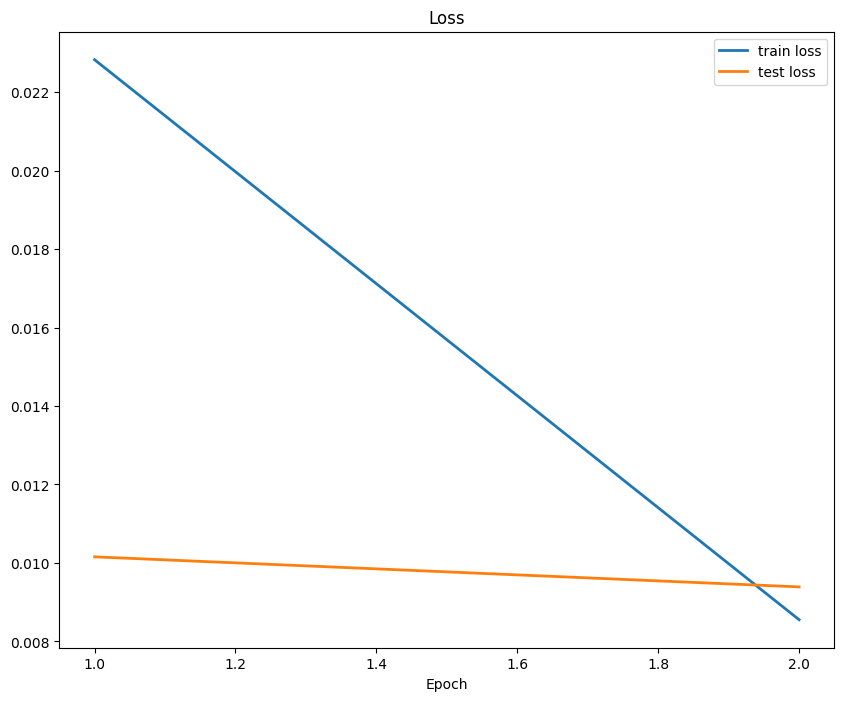

In [69]:
plot_loss_history(vgg_stats[0], vgg_stats[1])

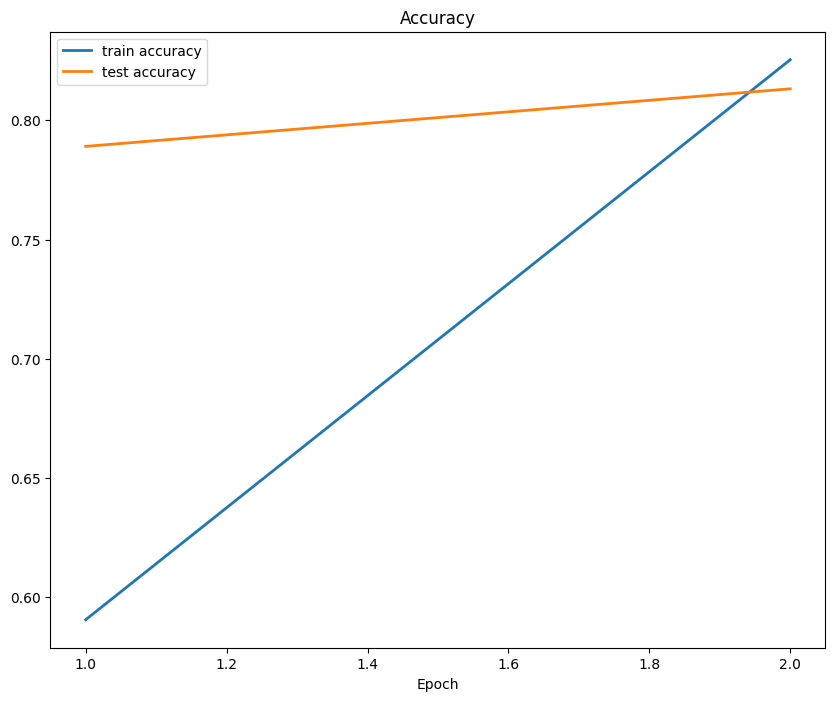

In [70]:
plot_acc_history(vgg_stats[2], vgg_stats[3])

In [71]:
print('Final accuracy =', vgg_stats[3][-1])

Final accuracy = 0.8132102272727273


Теперь попробуем дообучить ResNet18

In [72]:
resnet = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [74]:
resnet.fc = nn.Linear(512, len(classes))

In [75]:
resnet = resnet.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(), lr=1e-4)

epochs = 2

In [76]:
resnet_stats = train_model(resnet, train_loader, val_loader, epochs, optimizer, criterion, device)

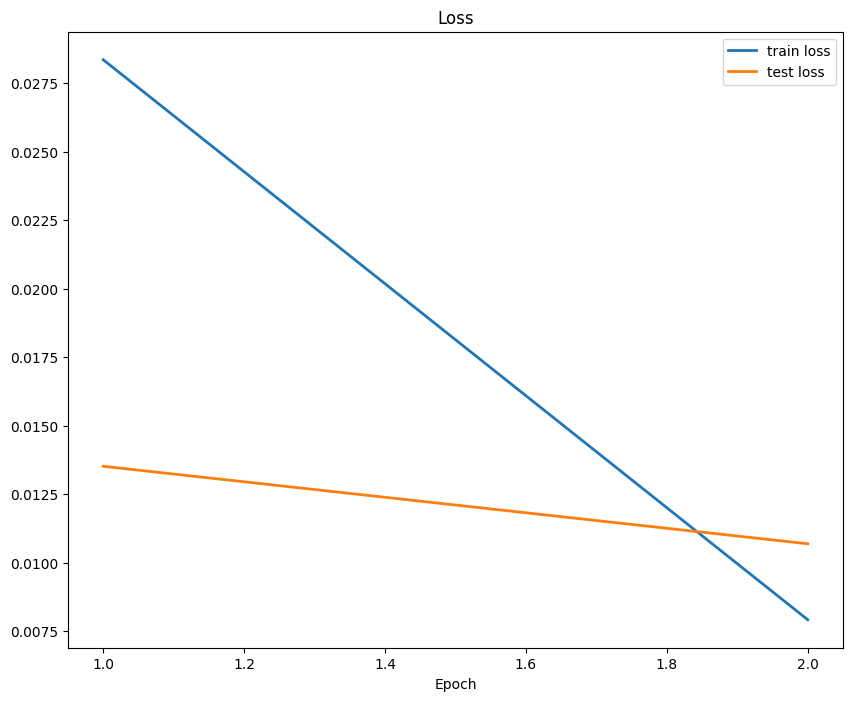

In [77]:
plot_loss_history(resnet_stats[0], resnet_stats[1])

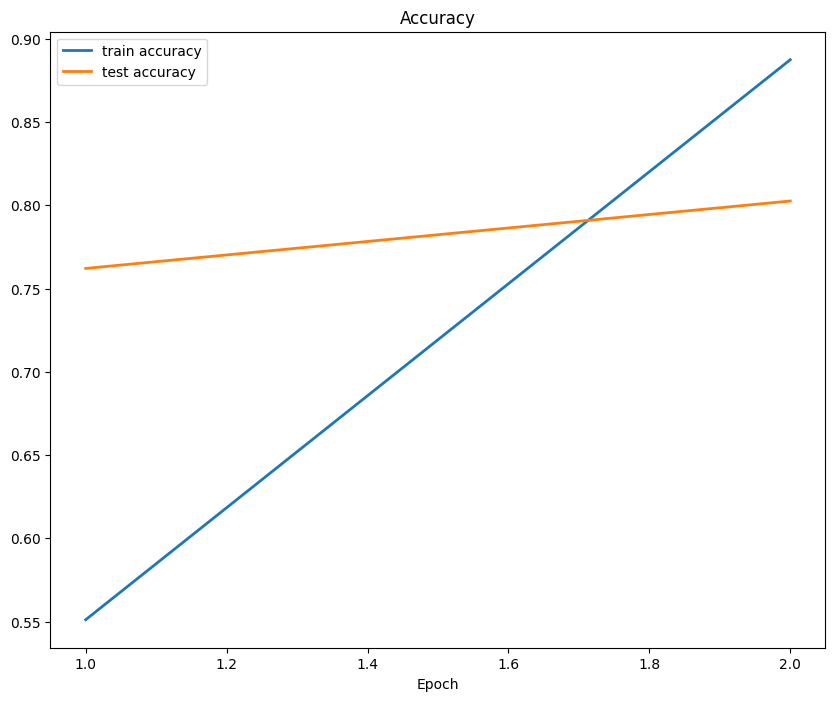

In [78]:
plot_acc_history(resnet_stats[2], resnet_stats[3])

In [79]:
print('Final accuracy =', resnet_stats[3][-1])

Final accuracy = 0.8025568181818182


Результаты у нейросетей получились примерно одинаковые: accuracy = 0.81. Рассмотрим реснет более детально: построим для него матрицу неточностей и посчитаем top k acc:

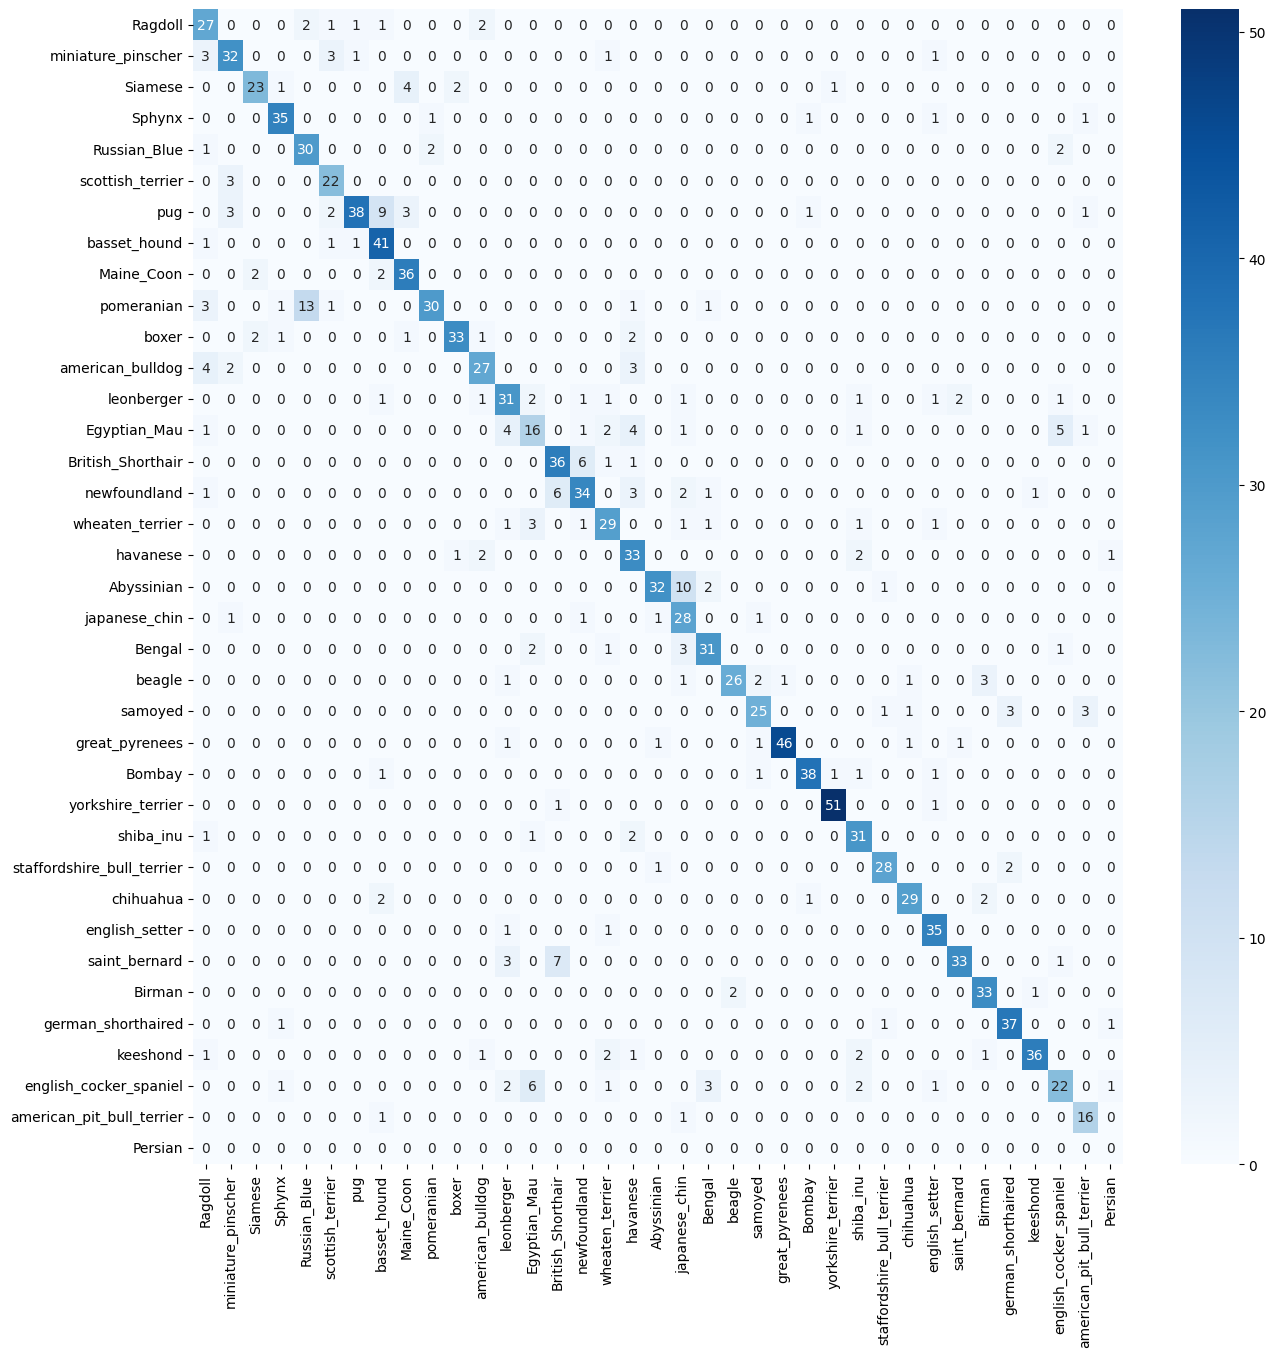

In [80]:
plot_confusion_matrix(resnet, val_loader)

Модель хорошо справляется с задачей: почти все элементы датасета находятся на диагонали матрицы неточностей.


Точность бинарной классификации - кошки vs собаки:

К сожалению, из датасета нельзя быстро понять, какая из пород относится к собакам, а какая к кошкам, а ручную разметку делать очень долго.

Прикинем точность по построенной конфьюжен матрице. Посмотрим на ячейки с большими числами, которые не лежат на диагонали. Там видно несколько случаев, когда модель путает породы собак (или породы кошек). Но иногда она путает собак и кошек в принципе (например, 12 раз она перепутала бульдога с мейн куном). Но в целом таких случаев не так много - не больше 50. Значит, точность классификации кошек и собак равна ~96% (или даже выше)


In [84]:
1 - (50 / len(val_dataset))

0.9659863945578231